In [2]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import pdb
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
num_epochs = 5
num_classes = 10
batch_size = 15
learning_rate = 0.001

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
print('Training Data')
print(' - Number of digit:', train_dataset.data.cpu().numpy().shape)

Training Data
 - Number of digit: (60000, 28, 28)


In [6]:
print('Test Data')
print(' - Number of digit:', test_dataset.data.cpu().numpy().shape)

Test Data
 - Number of digit: (10000, 28, 28)


![title](network_flowchart.png)

In [7]:
#Layer 1
filter_size1 = 5
num_filter1  =16
# Layer 2
filter_size2 = 5
num_filter2  =36
#Fully connected
num_neuron =  128
num_channels = 1

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [11]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [13]:
example_data.shape

torch.Size([15, 1, 28, 28])

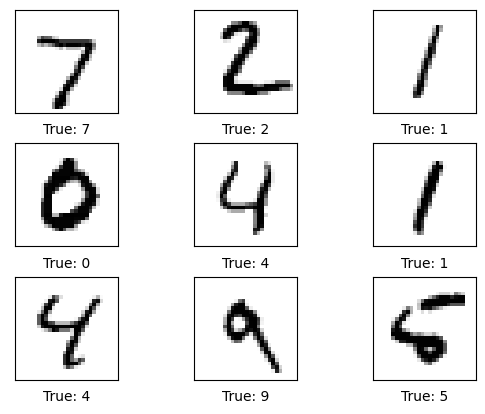

In [14]:
plot_images(example_data[0:9].permute(0,2,3,1).cpu().numpy(),example_targets[0:9].cpu().numpy())

In [15]:
example_data.permute(0,2,3,1).shape

torch.Size([15, 28, 28, 1])

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter1, kernel_size=filter_size1,padding=2)
        self.conv2 = nn.Conv2d(num_filter1, num_filter2, kernel_size=filter_size2,padding=2)
        self.relu  = nn.ReLU()
        self.fc1 = nn.Linear(1764, num_neuron)
        self.fc2 = nn.Linear(num_neuron, 10)

    def forward(self, x):
        x=self.conv1(x)
        x= F.max_pool2d(x,2)
        w1=self.relu(x)
        x = self.conv2(w1)
        x=self.relu(x)
        w2=F.max_pool2d(x,2)
        #pdb.set_trace()
        x = w2.view(-1, 1764)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return (x,w1,w2)

In [17]:
momentum=0.9
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [18]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

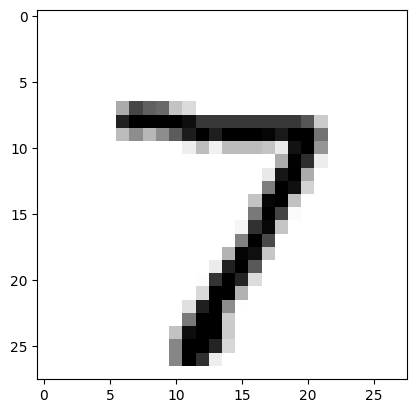

In [19]:
image1 = example_data[0].permute(1,2,0).cpu().numpy()
plot_image(image1)

In [20]:
outputs = model(example_data[0].view(1,1,28,28))

In [21]:
outputs[1].shape

torch.Size([1, 16, 14, 14])

In [22]:
def plot_conv_weights(weights, input_channel=0):
    w=weights
    w_min = np.min(w)
    w_max = np.max(w)
    #shape =[filter_size,filter_size,num_channels,num_filters]
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    print(num_filters)
    # Number of grids to plot.
    # Create figure with a grid of sub-plots.
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

16


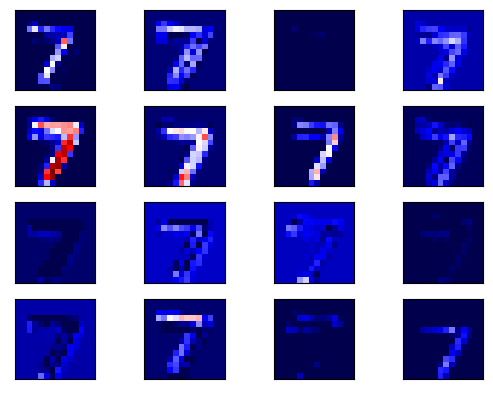

In [23]:
plot_conv_weights((outputs[1].permute(2,3,0,1).detach().cpu().numpy()))

In [24]:
mm = model.float()
filters = mm.modules
body_model = [i for i in mm.children()]

In [28]:
filters

<bound method Module.modules of Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (fc1): Linear(in_features=1764, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)>

In [29]:
body_model

[Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(),
 Linear(in_features=1764, out_features=128, bias=True),
 Linear(in_features=128, out_features=10, bias=True)]

In [25]:

layer1 = body_model[1]
tensor = layer1.weight.permute(2,3,1,0).data.cpu().numpy()

36


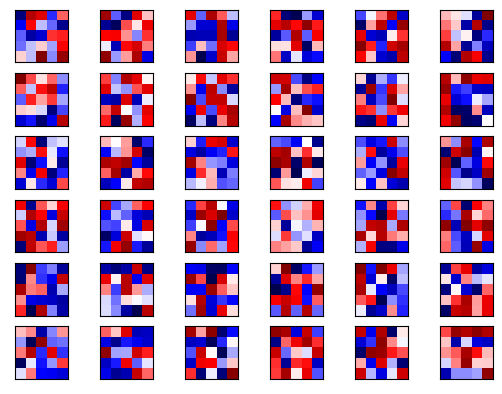

In [26]:
plot_conv_weights(tensor)

In [27]:
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs[0], labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/4000], Loss: 2.2809
Epoch [1/5], Step [200/4000], Loss: 2.2501
Epoch [1/5], Step [300/4000], Loss: 2.0848
Epoch [1/5], Step [400/4000], Loss: 1.4624
Epoch [1/5], Step [500/4000], Loss: 0.5721
Epoch [1/5], Step [600/4000], Loss: 0.4749
Epoch [1/5], Step [700/4000], Loss: 0.1733
Epoch [1/5], Step [800/4000], Loss: 0.2332
Epoch [1/5], Step [900/4000], Loss: 0.2092
Epoch [1/5], Step [1000/4000], Loss: 0.5266
Epoch [1/5], Step [1100/4000], Loss: 0.3391
Epoch [1/5], Step [1200/4000], Loss: 0.6980
Epoch [1/5], Step [1300/4000], Loss: 0.1428
Epoch [1/5], Step [1400/4000], Loss: 0.1686
Epoch [1/5], Step [1500/4000], Loss: 0.1722
Epoch [1/5], Step [1600/4000], Loss: 0.1498
Epoch [1/5], Step [1700/4000], Loss: 0.3852
Epoch [1/5], Step [1800/4000], Loss: 0.0663
Epoch [1/5], Step [1900/4000], Loss: 0.1704
Epoch [1/5], Step [2000/4000], Loss: 0.3970
Epoch [1/5], Step [2100/4000], Loss: 0.2378
Epoch [1/5], Step [2200/4000], Loss: 0.1341
Epoch [1/5], Step [2300/4000], Loss: 0.11

Epoch [5/5], Step [2900/4000], Loss: 0.0022
Epoch [5/5], Step [3000/4000], Loss: 0.0053
Epoch [5/5], Step [3100/4000], Loss: 0.0020
Epoch [5/5], Step [3200/4000], Loss: 0.0002
Epoch [5/5], Step [3300/4000], Loss: 0.0019
Epoch [5/5], Step [3400/4000], Loss: 0.0582
Epoch [5/5], Step [3500/4000], Loss: 0.0151
Epoch [5/5], Step [3600/4000], Loss: 0.0053
Epoch [5/5], Step [3700/4000], Loss: 0.0062
Epoch [5/5], Step [3800/4000], Loss: 0.0044
Epoch [5/5], Step [3900/4000], Loss: 0.0606
Epoch [5/5], Step [4000/4000], Loss: 0.0503


In [30]:
# Split the test-set into smaller batches of this size.
test_batch_size = batch_size
model.eval() 
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = test_dataset.data.cpu().numpy().shape[0]
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    cls_true = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[0].data, 1)
            total += labels.size(0)
            #pdb.set_trace()
            correct += (predicted == labels).sum().item()
            # The ending index for the next batch is denoted j.
            j = min(i + test_batch_size, num_test)

            # Calculate the predicted class using TensorFlow.
            cls_pred[i:j] = predicted.detach().cpu().numpy()
            cls_true[i:j] =labels.detach().cpu().numpy()
            # Set the start-index for the next batch to the
            # end-index of the current batch.
            i = j

    # Convenience variable for the true class-numbers of the test-set.


    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred, cls_true=cls_true)

In [31]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = test_dataset.data.cpu().numpy()[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = test_dataset.targets.cpu().numpy()[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [32]:
test_dataset.targets.cpu().numpy().shape

(10000,)

In [33]:
def plot_confusion_matrix(cls_pred,cls_true):
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)

C:\Users\ahmedkm\AppData\Local\Temp\ipykernel_11100\1522424286.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)
C:\Users\ahmedkm\AppData\Local\Temp\ipykernel_11100\1522424286.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Accuracy on Test-Set: 98.8% (9876 / 10000)
Example errors:


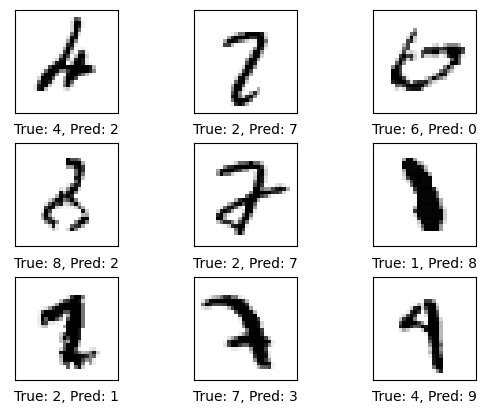

Confusion Matrix:
[[ 975    0    1    0    0    0    0    1    3    0]
 [   0 1125    2    1    0    1    1    1    4    0]
 [   1    1 1021    3    0    0    0    3    3    0]
 [   1    0    0 1002    0    2    0    2    2    1]
 [   0    0    3    0  964    0    1    3    1   10]
 [   2    0    0   10    0  878    2    0    0    0]
 [   5    2    0    1    2    4  943    0    1    0]
 [   0    2    5    1    0    0    0 1017    1    2]
 [   1    0    2    3    0    1    0    2  964    1]
 [   2    2    0    4    6    2    0    4    2  987]]


In [34]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [ ]:


# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')